In [1]:
import pandas as pd
import numpy as np
import torch
from scipy.stats import gamma, norm
from darts.models import RNNModel,RegressionModel , RandomForest, XGBModel
from darts.metrics import rmse, mape,mae, smape
# from darts.utils.preprocessing import Scaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from darts.dataprocessing.transformers.scaler import Scaler
# from darts.ad import ThresholdAD
from darts import TimeSeries

import pywt
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import json
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
import os


from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.enum.shapes import MSO_SHAPE
from pptx.dml.color import RGBColor

import geopandas as gpd
from shapely.geometry import Point
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
from scipy.stats import pearsonr

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


c:\Users\varas\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Read and preprocess the input data


In [2]:

def fit_gamma(precip: pd.Series) -> tuple:
    non_zero = precip[precip > 0]
    if len(non_zero) == 0:
        return np.nan, np.nan, 1.0
    shape, _, scale = gamma.fit(non_zero, floc=0)
    zero_prob = (precip == 0).mean()
    return shape, scale, zero_prob


def compute_spi(roll: pd.Series, shape: float, scale: float, zero_prob: float) -> np.ndarray:
    # probs = zero_prob + (1 - zero_prob) * gamma.cdf(roll, shape, scale=scale)
    probs = np.where(
    roll.isna(),
    np.nan,
    zero_prob + (1 - zero_prob) * gamma.cdf(roll, shape, scale=scale)
    )
    probs = np.clip(probs, 1e-10, 1 - 1e-10)
    return norm.ppf(probs)


def process_station(df_station: pd.DataFrame) -> pd.DataFrame:
    df_station = df_station.sort_values('ds').reset_index(drop=True)
    # shape, scale, zero_prob = fit_gamma(df_station['precip'])
    result = {'ds': df_station['ds']}

    for s in [1, 3, 6, 9, 12, 24]:
        roll = df_station['precip'].rolling(s, min_periods=s).sum()
        shape, scale, zero_prob = fit_gamma(roll.dropna())

        spi = compute_spi(roll, shape, scale, zero_prob)
        # z-score manually
        mean, std = np.nanmean(spi), np.nanstd(spi)
        result[f'SPI_{s}'] = (spi - mean) / std

    result_df = pd.DataFrame(result)
    result_df['station_id'] = df_station['station_id'].iloc[0]
    return result_df


# Load & aggregate to monthly totals
df = (
    pd.read_csv('../main_data.csv', parse_dates=['data'])
      .assign(ds=lambda d: d['data'].dt.to_period('M').dt.to_timestamp())
      .groupby(['station_id', 'ds'])['rrr24']
      .sum()
      .reset_index(name='precip')
)

# Compute SPI for each station
spi_list = [process_station(g) for _, g in df.groupby('station_id')]
all_spi = pd.concat(spi_list, ignore_index=True)


class TaylorDiagram

In [3]:

class TaylorDiagram:
    def __init__(self, ref_std, fig=None, rect=111, label='Reference'):
        self.ref_std = ref_std
        self.sample_points = []

        self.fig = fig if fig is not None else plt.figure(figsize=(8, 6))
        self.ax = self.fig.add_subplot(rect, polar=True)

        # Configure polar axes
        self.ax.set_theta_zero_location('E')

        self.ax.set_theta_direction(-1)
        self.ax.set_theta_offset(np.pi / 2)
        self.ax.set_ylim(0, 1.5 * ref_std)
        self.ax.set_thetamin(0)
        self.ax.set_thetamax(90)

        # Set up correlation coefficient grid
        self._setup_axes()

        # Plot reference point
        self.ax.plot([0], [ref_std], 'k*', markersize=12, label=label)

    def _setup_axes(self):
        corrs = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.99, 1.0])
        angles = np.arccos(corrs)

        self.ax.set_thetagrids(np.degrees(angles), labels=[f"{c:.2f}" for c in corrs], fontsize=10)
        self.ax.set_rlabel_position(135)
        self.ax.set_ylabel('Standard Deviation', fontsize=12)

        # Add radial grid lines manually
        for angle in angles:
            self.ax.plot([angle, angle], [0, self.ax.get_ylim()[1]], color='lightgray', linestyle='--', linewidth=0.5)

    def add_sample(self, stddev, corrcoef, label, marker='o', color=None):
        theta = np.arccos(corrcoef)
        point, = self.ax.plot(theta, stddev, marker=marker, label=label, color=color, markersize=8)
        self.sample_points.append(point)

    def add_contours(self, levels=6, cmap='coolwarm', linewidths=1.2):
        rs, ts = np.meshgrid(
            np.linspace(0, self.ax.get_ylim()[1], 300),
            np.linspace(0, np.pi / 2, 300)
        )
        rms = np.sqrt(
            self.ref_std**2 + rs**2 - 2 * self.ref_std * rs * np.cos(ts)
        )
        contours = self.ax.contour(
            ts, rs, rms,
            levels=np.linspace(0, self.ax.get_ylim()[1], levels),
            cmap=cmap,
            linewidths=linewidths
        )
        self.fig.colorbar(contours, ax=self.ax, pad=0.1, orientation='vertical', label="RMS Difference")
        return contours

    def show(self, title='Taylor Diagram'):
        self.ax.set_title(title, fontsize=14, pad=20)
        self.ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
        plt.tight_layout()
        plt.show()


Define Models and train


In [7]:

class WBBLSTMModel:
    def __init__(self, wavelet='db1', level=1, **lstm_kwargs):
        self.wavelet = wavelet
        self.level = level
        self.lstm_kwargs = lstm_kwargs
        self.lstm_model = RNNModel(model='LSTM', **lstm_kwargs)
        
    def wavelet_decompose(self, series: TimeSeries):
        coeffs = pywt.wavedec(series.values().flatten(), self.wavelet, level=self.level)
        return coeffs
    
    def wavelet_reconstruct(self, coeffs):
        return pywt.waverec(coeffs, self.wavelet)
    
    def fit(self, series: TimeSeries):
        # Decompose
        coeffs = self.wavelet_decompose(series)
        approx = coeffs[0]  # Use approximation coeffs as input to LSTM
        approx_series = TimeSeries.from_values(approx.reshape(-1, 1))
        
        # Fit the internal LSTM model
        self.lstm_model.fit(approx_series)

    def predict(self, n,series):
        # 1) Decompose historical series into coeffs
        hist_coeffs = self.wavelet_decompose(series)
        hist_approx, *hist_details = hist_coeffs

        # 2) Forecast only the approximation coeffs (with correct time index)
        approx_ts = self.lstm_model.predict(n, series=series)
        approx_pred = approx_ts.values().flatten()

        # 3) Build a new approximation array: [historic approx | predicted approx]
        full_approx = np.concatenate([hist_approx, approx_pred])


        dummy_signal = np.zeros_like(approx_pred)

        # 2. Decompose dummy to get the correct coeff shapes
        dummy_coeffs = pywt.wavedec(dummy_signal, self.wavelet, level=self.level)

        full_coeffs   = [full_approx] + [np.zeros_like(c) for c in dummy_coeffs[1:]]
        print("Full approx length:", len(full_approx))
        print("Expected shapes:")
        for i, c in enumerate(dummy_coeffs):
            print(f"  Coeff {i}: shape = {c.shape}")

        print("\nYour full_coeffs shapes:")
        for i, c in enumerate(full_coeffs):
                print(f"  Coeff {i}: shape = {c.shape}")

        

        # 3. Replace only the *approximation level* with your forecast (but RESHAPED to the correct length)
        approx_pred_downsampled = pywt.wavedec(approx_pred, self.wavelet, level=self.level)[0]

        # 4. Now use it with the correct detail coeff shapes
        coeffs = [approx_pred_downsampled] + [np.zeros_like(c) for c in dummy_coeffs[1:]]

        # 5. Reconstruct
        full_series = self.wavelet_reconstruct(coeffs)

        # 5) zero out all detail levels (you could also keep hist_details if you want)

        # # 6) reconstruct the full signal
        # full_series   = self.wavelet_reconstruct(full_coeffs)

        # 7) extract just the last n points (the forecast window)
        forecast_vals = full_series[-n:]

        # 8) wrap back into TimeSeries with the right ds index
        return TimeSeries.from_times_and_values(
            approx_ts.time_index,
            forecast_vals.reshape(-1, 1),
            columns=approx_ts.components
        )
    def save(self, path):
        # os.makedirs(path, exist_ok=True)

        # Save LSTM model
        self.lstm_model.save(path)

        # Save wavelet settings and kwargs
        meta = {
        'wavelet': self.wavelet,
            'level': self.level,
            'lstm_kwargs': self.lstm_kwargs
        }

        with open(os.path.join(os.path.dirname(path), "WBILSTMmeta.json"), "w") as f:
            json.dump(meta, f)

    @classmethod
    def load(cls, path):
        with open(os.path.join(os.path.dirname(path), "WBILSTMmeta.json"), "r") as f:
            meta = json.load(f)


        wavelet = meta['wavelet']
        level = meta['level']
        lstm_kwargs = meta['lstm_kwargs']
        instance = cls(wavelet=wavelet, level=level, **lstm_kwargs)

        # instance = cls(**meta)
        instance.lstm_model = RNNModel.load(path)
        return instance



window_size = 3
num_epochs=300
horizon = 12 

def train_val_split_and_scale(series):
    train, val = series.split_before(0.8)
    scaler = Scaler()
    train_scaled = scaler.fit_transform(train)
    val_scaled   = scaler.transform(val)
    # return train_scaled, val_scaled, scaler
    return train, val,scaler
model_constructors = {
       'ExtraTF': lambda: XGBModel(
         lags=window_size,
         output_chunk_length=horizon,
         random_state=SEED,
         objective='reg:squarederror'
    ),
    'RandomRF': lambda: RandomForest(
         lags=window_size,
         output_chunk_length=horizon,
         n_estimators=200,
         criterion="absolute_error",
         random_state=SEED
    ),
    'SVR': lambda: RegressionModel(
         model=SVR(kernel='rbf'),
         lags=window_size,
         output_chunk_length=horizon
    ),
    'LSTM': lambda: RNNModel(
         model='LSTM',
         input_chunk_length=window_size,
         output_chunk_length=horizon,
         hidden_dim=25,
         n_rnn_layers=2,
         dropout=0.1,
         batch_size=16,
         n_epochs=num_epochs,
         optimizer_kwargs={'lr':1e-3},
         random_state=SEED
    ),
    'WBBLSTM'   : lambda: WBBLSTMModel(
        wavelet='db1',
        level=1,
        input_chunk_length=window_size,
        output_chunk_length=horizon,
        hidden_dim=25,
        n_rnn_layers=2,
        dropout=0.1,
        batch_size=16,
        n_epochs=num_epochs,
        optimizer_kwargs={'lr':1e-3},
        random_state=SEED
    )
}

results = {}  
base_dir = "all_results3"
os.makedirs(base_dir, exist_ok=True)
listofStaion = [40700]
listofcols = ['SPI_1','SPI_3', 'SPI_6', 'SPI_9', 'SPI_12', 'SPI_24']


for station_id, group in all_spi.groupby('station_id'):
    results[station_id] = {}
    if station_id not in listofStaion:
             continue
    for col in [c for c in group.columns if c.startswith("SPI_")]:
        if col not in listofcols:
            continue
        print(f"\n=== Station {station_id} | {col} ===")
        sub_df = group[['ds', col]].dropna()

        series = TimeSeries.from_dataframe(sub_df, time_col='ds', value_cols=col)
        

        train_s, val_s, scaler = train_val_split_and_scale(series)

        

        model_folder = os.path.join(base_dir, f"{station_id}/{col}")
        os.makedirs(model_folder, exist_ok=True)


        model_stats = {}
        forecasts = {}
        for name, mk in model_constructors.items():
            model_path = os.path.join(model_folder, name)
            if os.path.exists(model_path):
                print(f"Model {name} already trained. Skipping.")
                model_class = {
                    'LSTM': RNNModel,
                    'SVR': RegressionModel,
                    'RandomRF': RandomForest,
                    'ExtraTF': XGBModel,
                    'WBBLSTM': WBBLSTMModel
                }[name]
                print(f"!!!@@@-----Loading {name} model from {model_path}…")
                model = model_class.load(model_path)

            else:
                print(f"!!!@@@------Training {name}…", end='')
                model = mk()

                model.fit(series=train_s)
                model.save(model_path)

                print(" saved.")
            fc_scaled = model.predict(len(val_s), series=train_s)
            # forecast  = scaler.inverse_transform(fc_scaled)
            # o = val_s.values().flatten()
            # val_unscaled = scaler.inverse_transform(val_s)
            o = val_s.values().flatten()
            p = fc_scaled.values().flatten()

            corr = pearsonr(o, p)[0]
            if corr < 0:
                print('negative corr')
                p = -p
                corr = -corr

            rm   = np.sqrt(mean_squared_error(o, p))
            mae_v= mean_absolute_error(o, p)
            sm   = np.mean(2 * np.abs(o-p) / (np.abs(o)+np.abs(p))) * 100

            model_stats[name] = (np.std(o), np.std(p), corr, rm, mae_v, sm)
            forecasts[name] = fc_scaled

        results[station_id][col] = model_stats





=== Station 40700 | SPI_1 ===
!!!@@@------Training ExtraTF… saved.
negative corr
!!!@@@------Training RandomRF…

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.0 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


 saved.
negative corr
!!!@@@------Training SVR… saved.
Epoch 299: 100%|██████████| 19/19 [00:00<00:00, 82.62it/s, train_loss=0.195]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 19/19 [00:00<00:00, 82.26it/s, train_loss=0.195]
 saved.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.88it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.



negative corr
!!!@@@------Training WBBLSTM…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.0 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 299: 100%|██████████| 9/9 [00:00<00:00, 48.74it/s, train_loss=0.202] 

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 9/9 [00:00<00:00, 48.21it/s, train_loss=0.202]
 saved.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.50it/s]
Full approx length: 248
Expected shapes:
  Coeff 0: shape = (42,)
  Coeff 1: shape = (42,)

Your full_coeffs shapes:
  Coeff 0: shape = (248,)
  Coeff 1: shape = (42,)

=== Station 40700 | SPI_3 ===
!!!@@@------Training ExtraTF… saved.
!!!@@@------Training RandomRF…

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.0 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


 saved.
!!!@@@------Training SVR… saved.
Epoch 299: 100%|██████████| 19/19 [00:00<00:00, 78.97it/s, train_loss=0.106] 

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 19/19 [00:00<00:00, 78.15it/s, train_loss=0.106]
 saved.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.93it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.



negative corr
!!!@@@------Training WBBLSTM…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.0 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 299: 100%|██████████| 9/9 [00:00<00:00, 83.87it/s, train_loss=0.190] 

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 9/9 [00:00<00:00, 82.71it/s, train_loss=0.190]
 saved.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 45.32it/s]
Full approx length: 247
Expected shapes:
  Coeff 0: shape = (42,)
  Coeff 1: shape = (42,)

Your full_coeffs shapes:
  Coeff 0: shape = (247,)
  Coeff 1: shape = (42,)

=== Station 40700 | SPI_6 ===
!!!@@@------Training ExtraTF… saved.
negative corr
!!!@@@------Training RandomRF…

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.0 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


 saved.
negative corr
!!!@@@------Training SVR… saved.
Epoch 299: 100%|██████████| 19/19 [00:00<00:00, 89.62it/s, train_loss=0.101] 

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 19/19 [00:00<00:00, 89.20it/s, train_loss=0.101]
 saved.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s]
!!!@@@------Training WBBLSTM…

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.0 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 299: 100%|██████████| 9/9 [00:00<00:00, 87.88it/s, train_loss=0.101] 

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 9/9 [00:00<00:00, 87.03it/s, train_loss=0.101]
 saved.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s]
Full approx length: 245
Expected shapes:
  Coeff 0: shape = (42,)
  Coeff 1: shape = (42,)

Your full_coeffs shapes:
  Coeff 0: shape = (245,)
  Coeff 1: shape = (42,)

=== Station 40700 | SPI_9 ===
!!!@@@------Training ExtraTF… saved.
!!!@@@------Training RandomRF…

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.0 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


 saved.
negative corr
!!!@@@------Training SVR… saved.
Epoch 299: 100%|██████████| 19/19 [00:00<00:00, 70.24it/s, train_loss=0.0651]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 19/19 [00:00<00:00, 69.98it/s, train_loss=0.0651]
 saved.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 40.18it/s]
negative corr
!!!@@@------Training WBBLSTM…

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.0 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 299: 100%|██████████| 9/9 [00:00<00:00, 86.12it/s, train_loss=0.174] 

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 9/9 [00:00<00:00, 84.50it/s, train_loss=0.174]

GPU available: False, used: False



 saved.


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s]
Full approx length: 243
Expected shapes:
  Coeff 0: shape = (41,)
  Coeff 1: shape = (41,)

Your full_coeffs shapes:
  Coeff 0: shape = (243,)
  Coeff 1: shape = (41,)
negative corr

=== Station 40700 | SPI_12 ===
!!!@@@------Training ExtraTF… saved.
!!!@@@------Training RandomRF…

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.0 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


 saved.
!!!@@@------Training SVR… saved.
negative corr
Epoch 299: 100%|██████████| 19/19 [00:00<00:00, 88.78it/s, train_loss=0.0554]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 19/19 [00:00<00:00, 87.96it/s, train_loss=0.0554]

GPU available: False, used: False



 saved.


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.



negative corr
!!!@@@------Training WBBLSTM…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.0 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 299: 100%|██████████| 9/9 [00:00<00:00, 93.75it/s, train_loss=0.0828] 

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 9/9 [00:00<00:00, 91.84it/s, train_loss=0.0828]
 saved.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s]
Full approx length: 241
Expected shapes:
  Coeff 0: shape = (41,)
  Coeff 1: shape = (41,)

Your full_coeffs shapes:
  Coeff 0: shape = (241,)
  Coeff 1: shape = (41,)

=== Station 40700 | SPI_24 ===
!!!@@@------Training ExtraTF… saved.
negative corr
!!!@@@------Training RandomRF…

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.0 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


 saved.
!!!@@@------Training SVR… saved.
Epoch 299: 100%|██████████| 18/18 [00:00<00:00, 89.11it/s, train_loss=0.0381]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 18/18 [00:00<00:00, 88.67it/s, train_loss=0.0381]
 saved.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.49it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False



!!!@@@------Training WBBLSTM…

TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.0 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 299: 100%|██████████| 9/9 [00:00<00:00, 87.38it/s, train_loss=0.130]  

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 9/9 [00:00<00:00, 86.54it/s, train_loss=0.130]
 saved.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s]
Full approx length: 234
Expected shapes:
  Coeff 0: shape = (40,)
  Coeff 1: shape = (40,)

Your full_coeffs shapes:
  Coeff 0: shape = (234,)
  Coeff 1: shape = (40,)


Loop over stations & timescales, 
 forecast

std_p: 0.63, corr: 0.05, rmse: 1.12, mae_v: 0.92,sm: 152.39 - ExtraTF 
std_p: 0.29, corr: 0.12, rmse: 0.97, mae_v: 0.78,sm: 150.23 - RandomRF 
std_p: 0.18, corr: 0.07, rmse: 0.99, mae_v: 0.78,sm: 164.33 - SVR 
std_p: 0.80, corr: 0.11, rmse: 1.19, mae_v: 0.97,sm: 140.09 - LSTM 
std_p: 0.60, corr: 0.03, rmse: 1.12, mae_v: 0.92,sm: 151.79 - WBBLSTM 


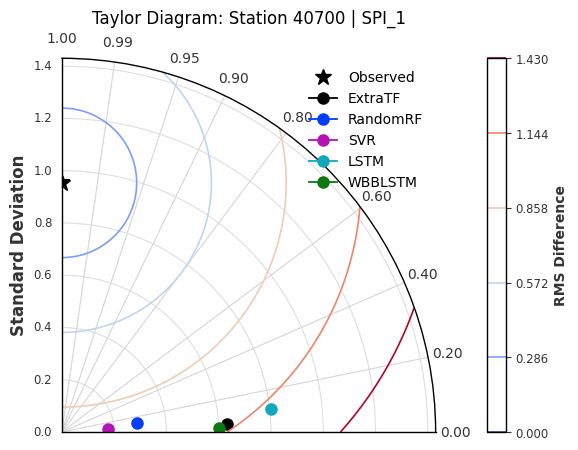

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.0 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Best model1 for 40700 | SPI_1: LSTM
Best model2 for 40700 | SPI_1: RandomRF
Best model3 for 40700 | SPI_1: RandomRF
Epoch 299: 100%|██████████| 25/25 [00:00<00:00, 89.11it/s, train_loss=0.243]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 25/25 [00:00<00:00, 88.47it/s, train_loss=0.243]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.70it/s]


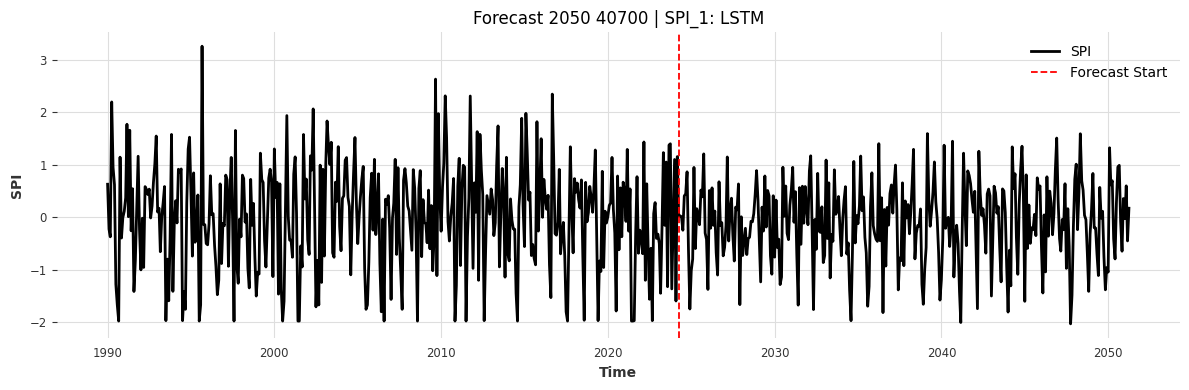

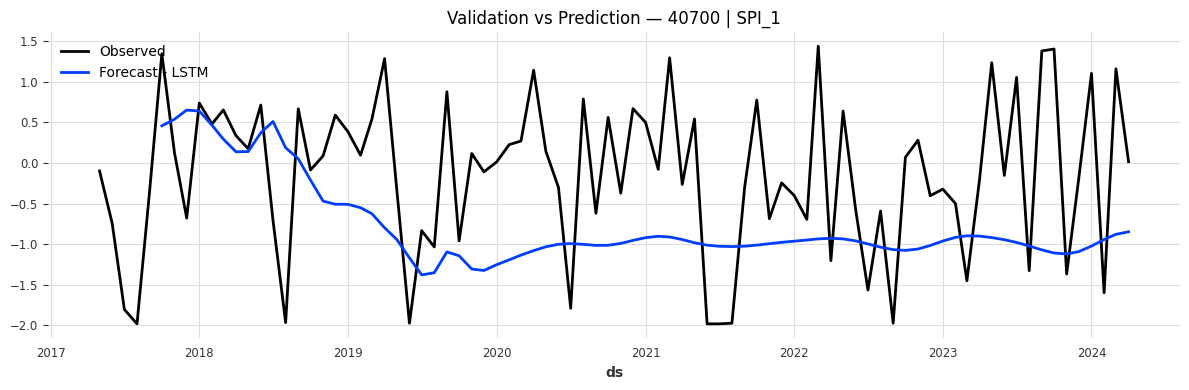

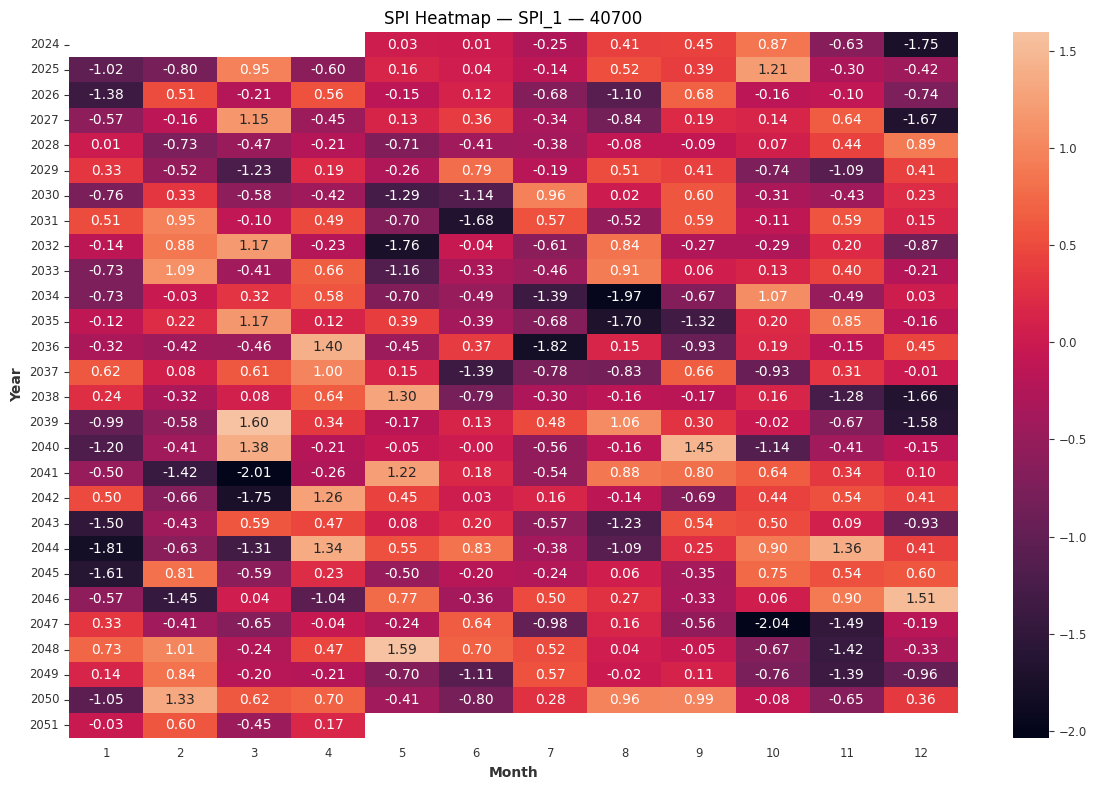

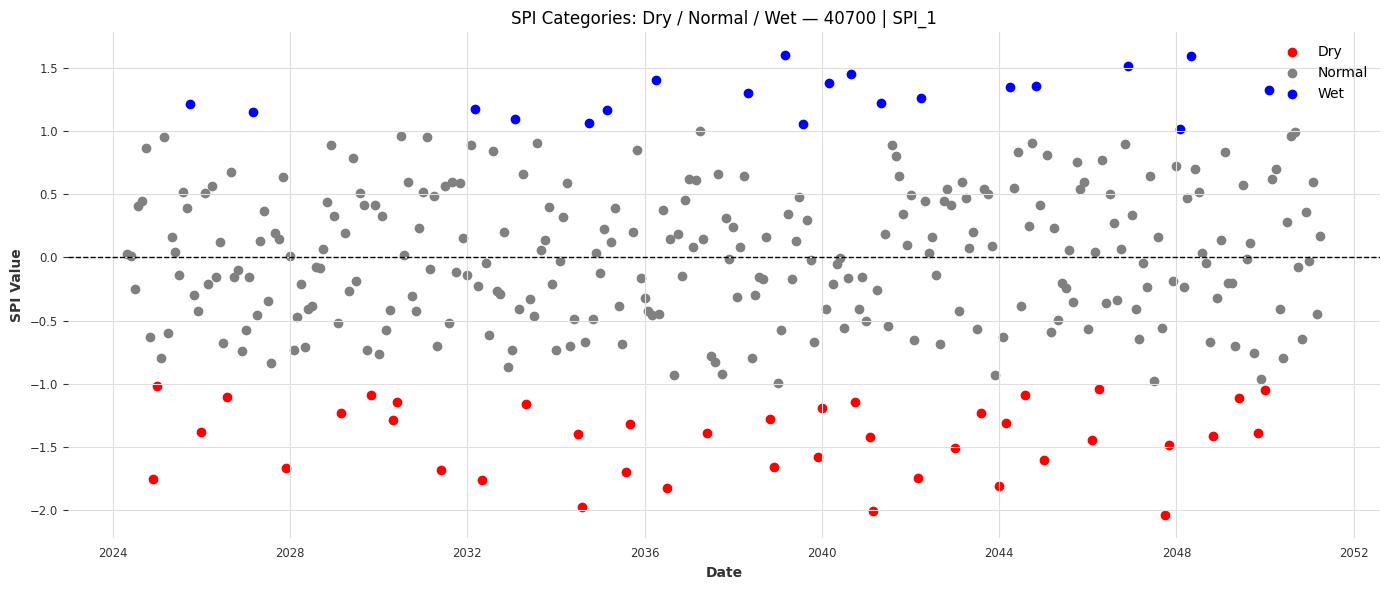

std_p: 0.70, corr: 0.06, rmse: 1.27, mae_v: 0.88,sm: 140.94 - ExtraTF 
std_p: 0.32, corr: 0.18, rmse: 1.06, mae_v: 0.70,sm: 142.47 - RandomRF 
std_p: 0.24, corr: 0.25, rmse: 1.04, mae_v: 0.67,sm: 147.02 - SVR 
std_p: 0.71, corr: 0.43, rmse: 1.02, mae_v: 0.71,sm: 124.70 - LSTM 
std_p: 0.86, corr: 0.05, rmse: 1.32, mae_v: 1.01,sm: 142.90 - WBBLSTM 


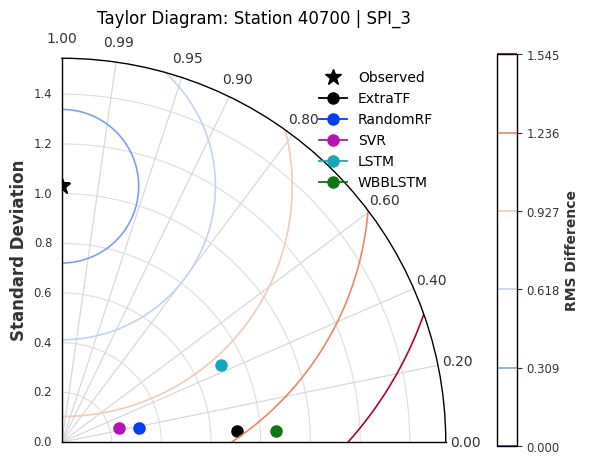

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.0 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Best model1 for 40700 | SPI_3: LSTM
Best model2 for 40700 | SPI_3: LSTM
Best model3 for 40700 | SPI_3: LSTM
Epoch 299: 100%|██████████| 25/25 [00:00<00:00, 95.79it/s, train_loss=0.0732] 

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 25/25 [00:00<00:00, 95.42it/s, train_loss=0.0732]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.73it/s]


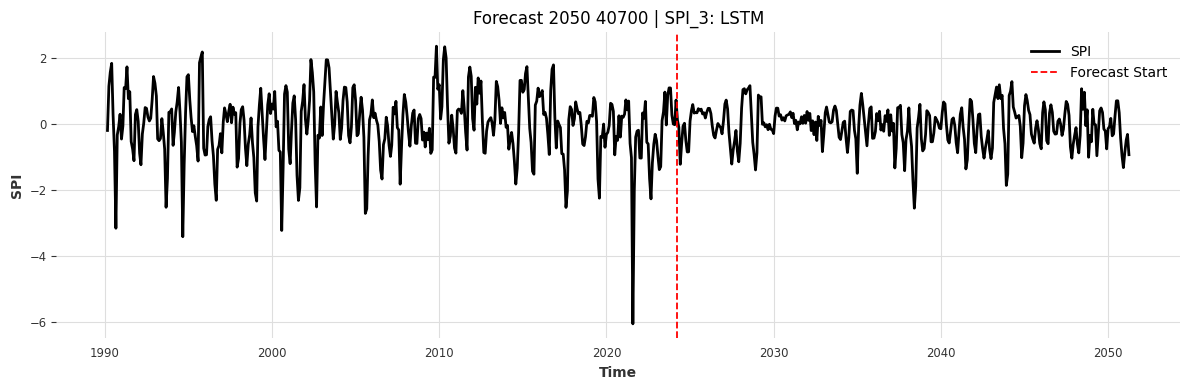

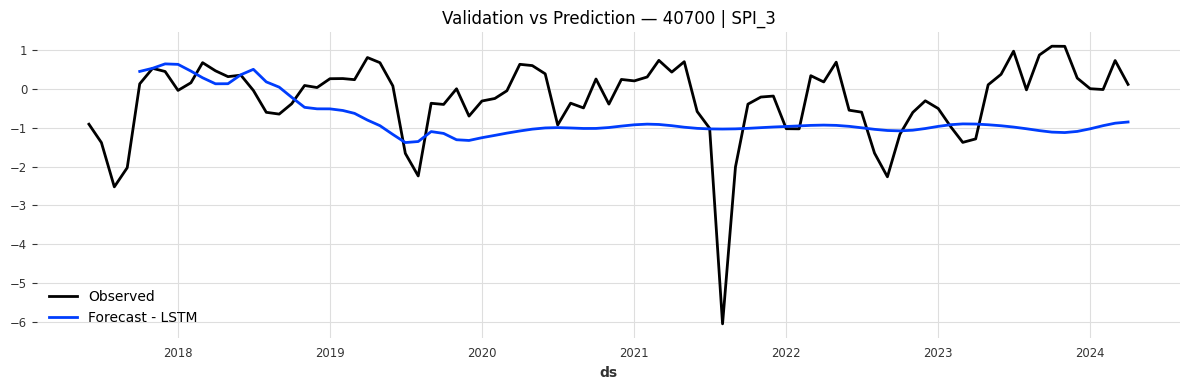

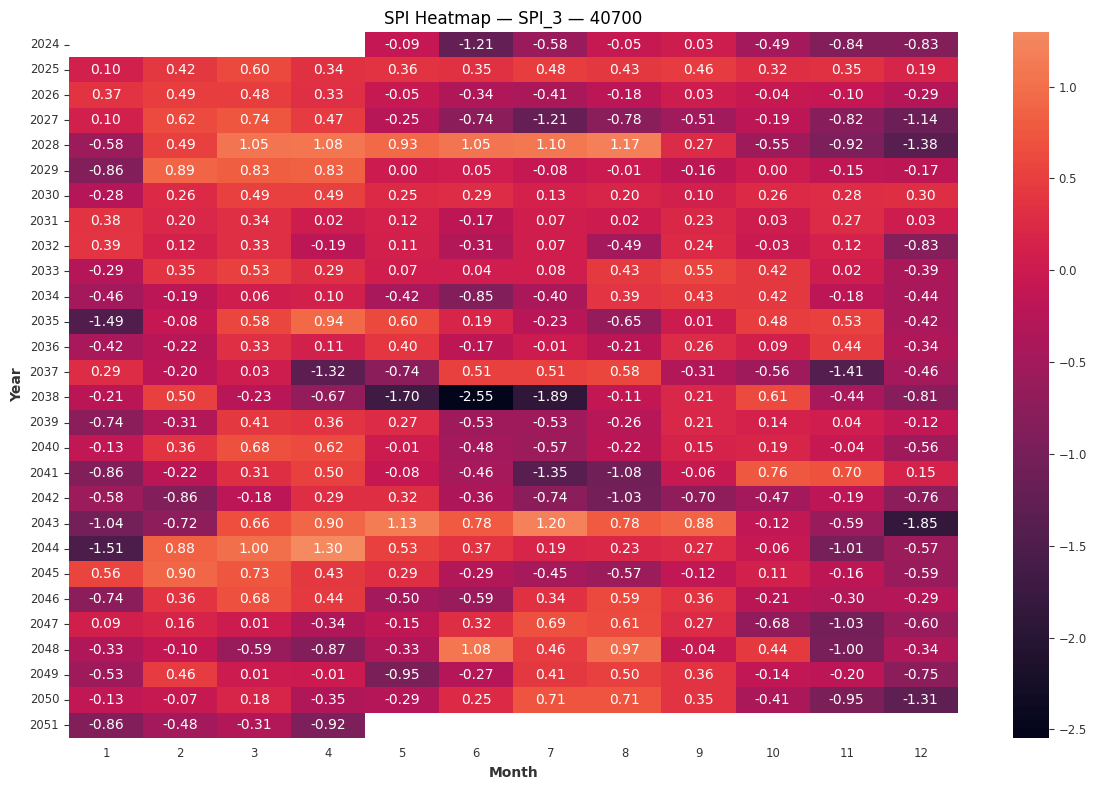

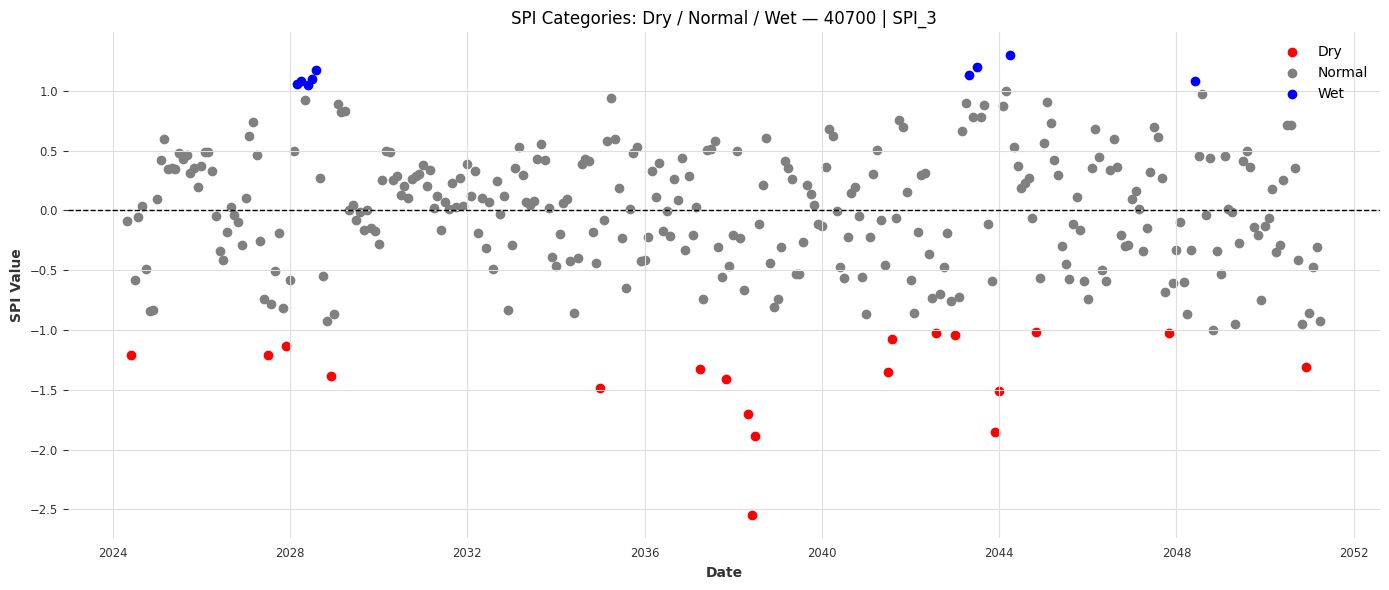

std_p: 0.64, corr: 0.06, rmse: 1.16, mae_v: 0.91,sm: 137.86 - ExtraTF 
std_p: 0.44, corr: 0.15, rmse: 1.03, mae_v: 0.82,sm: 137.77 - RandomRF 
std_p: 0.19, corr: 0.26, rmse: 0.97, mae_v: 0.75,sm: 152.25 - SVR 
std_p: 0.81, corr: 0.25, rmse: 1.49, mae_v: 1.24,sm: 148.41 - LSTM 
std_p: 1.19, corr: 0.06, rmse: 1.78, mae_v: 1.38,sm: 151.23 - WBBLSTM 


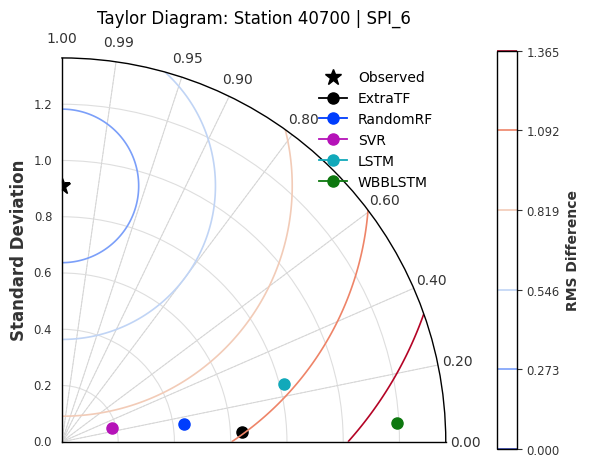

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.0 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Best model1 for 40700 | SPI_6: RandomRF
Best model2 for 40700 | SPI_6: SVR
Best model3 for 40700 | SPI_6: SVR
Epoch 299: 100%|██████████| 24/24 [00:00<00:00, 87.56it/s, train_loss=0.070]  

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 24/24 [00:00<00:00, 87.25it/s, train_loss=0.070]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.77it/s]


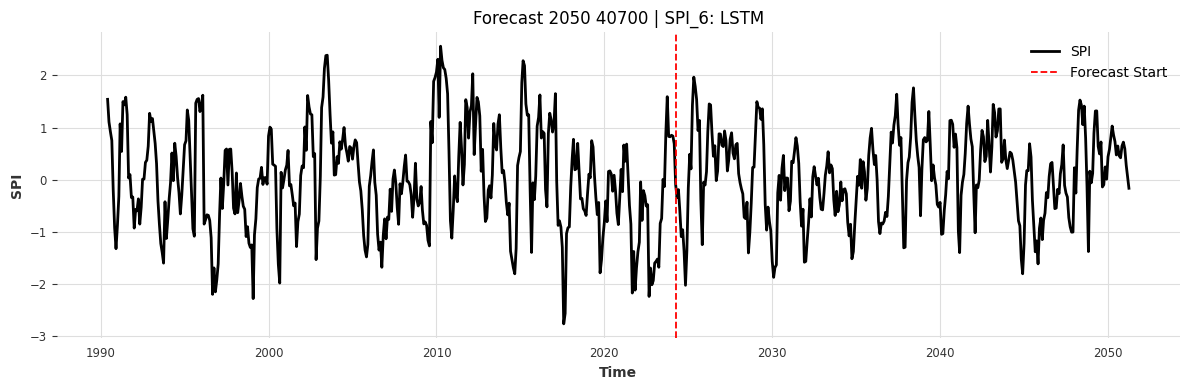

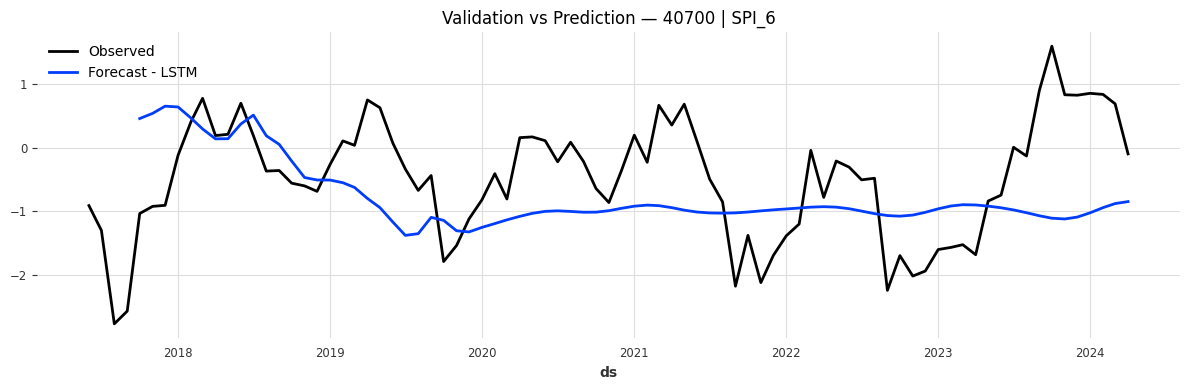

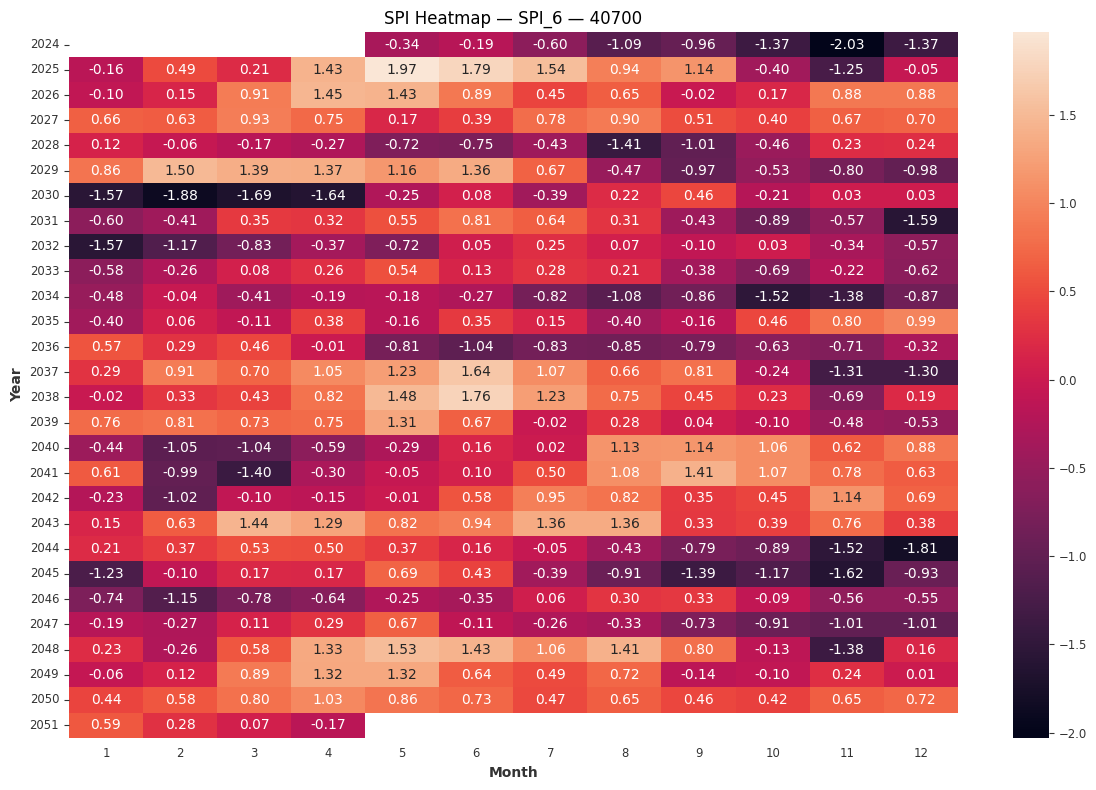

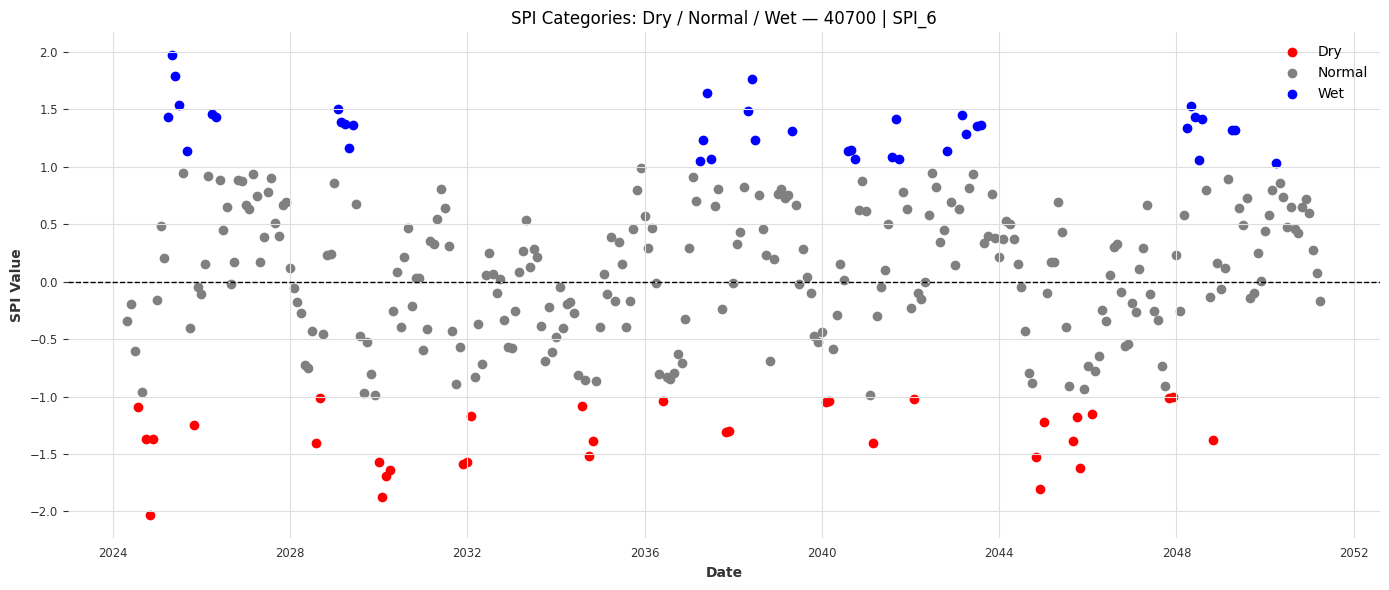

std_p: 0.69, corr: 0.20, rmse: 1.48, mae_v: 1.23,sm: 161.85 - ExtraTF 
std_p: 0.31, corr: 0.14, rmse: 0.90, mae_v: 0.70,sm: 115.61 - RandomRF 
std_p: 0.20, corr: 0.35, rmse: 1.01, mae_v: 0.81,sm: 168.41 - SVR 
std_p: 0.68, corr: 0.14, rmse: 1.14, mae_v: 0.91,sm: 132.99 - LSTM 
std_p: 0.88, corr: 0.25, rmse: 1.29, mae_v: 1.09,sm: 155.38 - WBBLSTM 


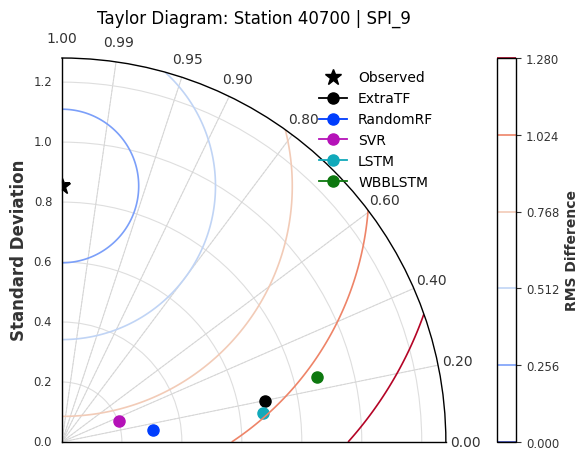

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.0 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Best model1 for 40700 | SPI_9: RandomRF
Best model2 for 40700 | SPI_9: RandomRF
Best model3 for 40700 | SPI_9: RandomRF
Epoch 299: 100%|██████████| 24/24 [00:00<00:00, 85.41it/s, train_loss=0.0536] 

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 24/24 [00:00<00:00, 85.11it/s, train_loss=0.0536]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


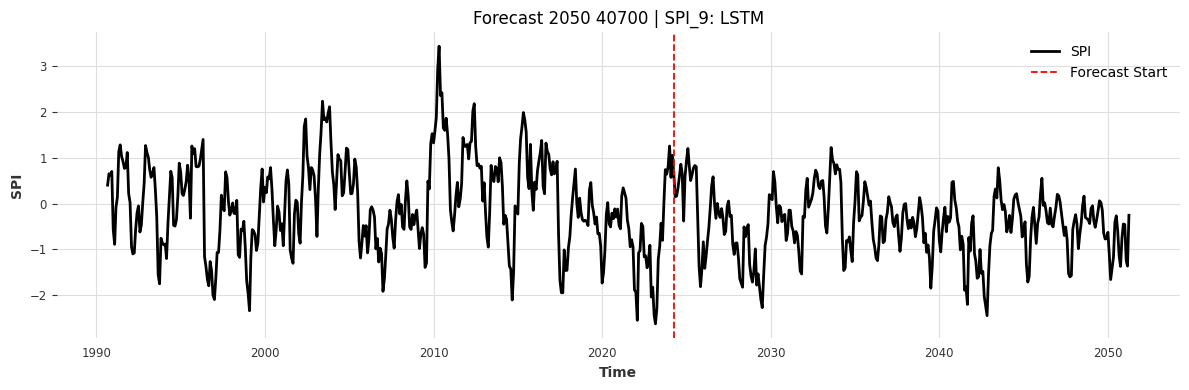

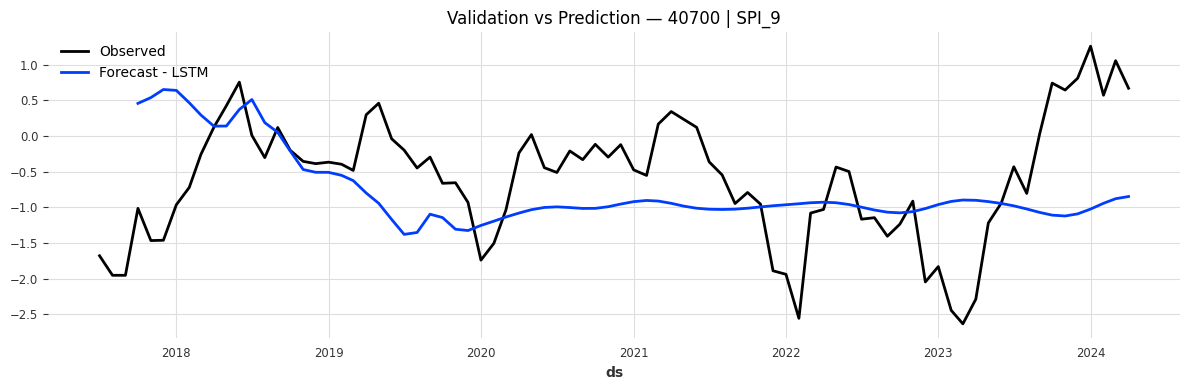

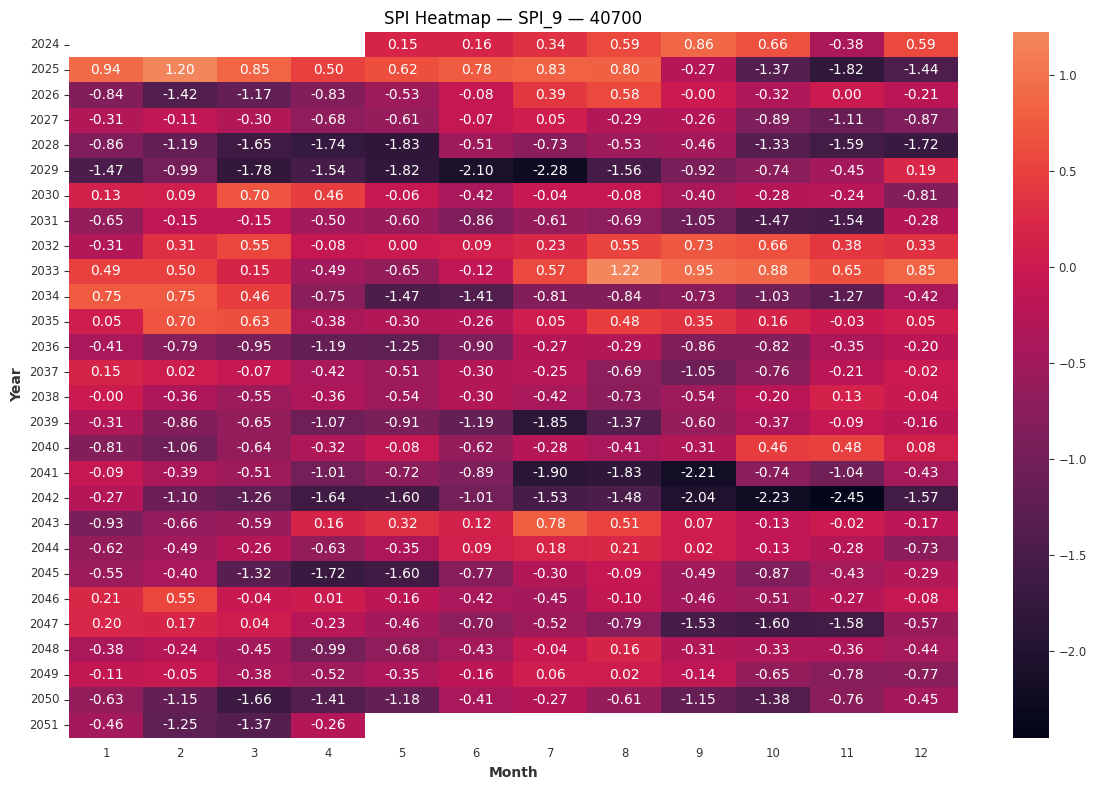

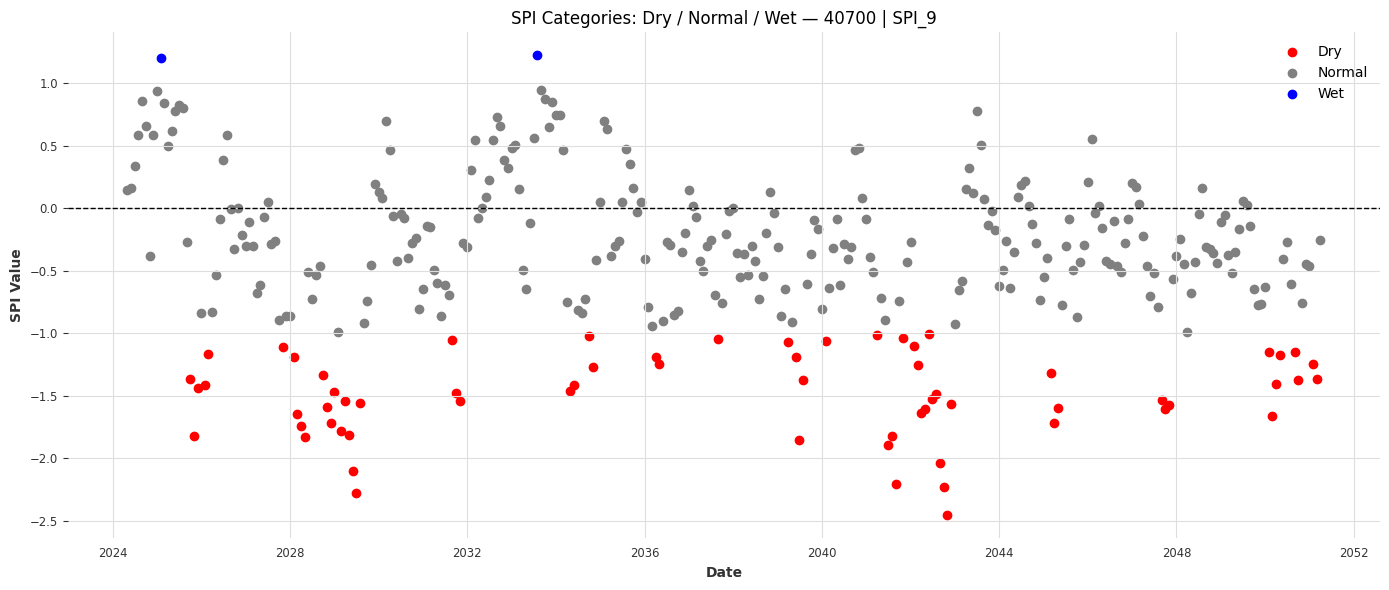

std_p: 0.66, corr: 0.50, rmse: 0.94, mae_v: 0.76,sm: 126.58 - ExtraTF 
std_p: 0.35, corr: 0.23, rmse: 1.00, mae_v: 0.80,sm: 146.76 - RandomRF 
std_p: 0.05, corr: 0.08, rmse: 1.18, mae_v: 0.98,sm: 184.90 - SVR 
std_p: 0.71, corr: 0.49, rmse: 1.12, mae_v: 0.94,sm: 145.13 - LSTM 
std_p: 1.31, corr: 0.40, rmse: 1.98, mae_v: 1.70,sm: 162.36 - WBBLSTM 


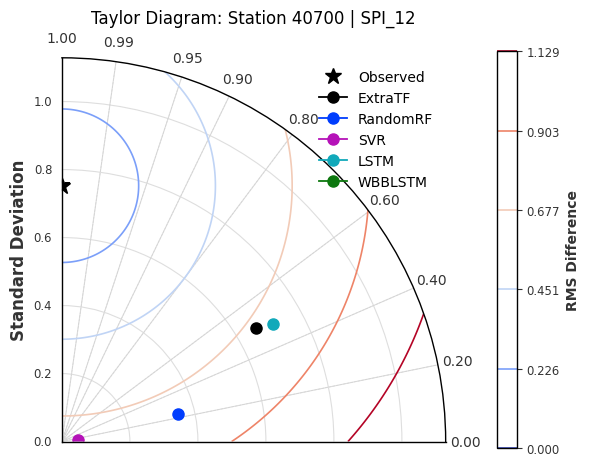

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.0 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Best model1 for 40700 | SPI_12: ExtraTF
Best model2 for 40700 | SPI_12: ExtraTF
Best model3 for 40700 | SPI_12: ExtraTF
Epoch 270:   4%|▍         | 1/24 [00:00<00:00, 76.88it/s, train_loss=0.0538]  

In [ ]:
def model_score(stats):
    std_o, std_p, corr, rmse, mape_val, _ = stats
    std_diff = abs(std_o - std_p)
    return (
        rmse + mape_val + std_diff - corr  # lower is better
    )

# listofStaion = [88107]
# listofcols = ['SPI_1','SPI_3', 'SPI_6', 'SPI_9', 'SPI_12', 'SPI_24']

for station_id, group in all_spi.groupby('station_id'):
    if station_id not in listofStaion:
             continue
    for col in [c for c in group.columns if c.startswith("SPI_")]:
            if col not in listofcols:
                continue
            model_stats = results[station_id][col]  
            sub_df = group[['ds', col]].dropna()

            series = TimeSeries.from_dataframe(sub_df, time_col='ds', value_cols=col)


            # Taylor Diagram
            ref_std = list(model_stats.values())[0][0]
            fig = plt.figure(figsize=(6, 6))
            taylor = TaylorDiagram(ref_std, fig, label='Observed')
            for name, (std_o, std_p, corr, rmse,mae_v,sm) in model_stats.items():
                print(f"std_p: {std_p:.2f}, corr: {corr:.2f}, rmse: {rmse:.2f}, mae_v: {mae_v:.2f},sm: {sm:.2f} - {name} ")
                if np.isnan(std_p) or np.isnan(corr) or std_p == 0:
                    print(f"⚠️ Skipping {name} due to invalid metrics.")
                    continue
                taylor.add_sample(std_p, corr, label=name)
            taylor.add_contours()
            plt.legend()
            plt.title(f"Taylor Diagram: Station {station_id} | {col}")
            plt.tight_layout()
            fig.savefig(os.path.join(base_dir, f"{station_id}/taylor_{col}.png"))
            plt.show()

            # Best model


            best_model = min(model_stats.items(), key=lambda x: model_score(x[1]))[0]
            best_model2 = min(model_stats.items(), key=lambda x: x[1][3])[0]
            best_model3 = min(model_stats.items(), key=lambda x: x[1][3])[0]

            # best_model = min(model_stats.items(), key=lambda x: x[1][4])[0]  # MAPE

            print(f"Best model1 for {station_id} | {col}: {best_model}")
            print(f"Best model2 for {station_id} | {col}: {best_model2}")
            print(f"Best model3 for {station_id} | {col}: {best_model3}")
            best_model = 'LSTM'
            best = model_constructors[best_model]()
            best.fit(series)
            

            # # Forecast to 2050
            horizon = (pd.Timestamp("2050-12-01") - series.end_time()).days // 30
            future = best.predict(horizon, series=series)


            if not isinstance(future.time_index, pd.DatetimeIndex):
                future = TimeSeries.from_times_and_values(
                    pd.date_range(
                        start=series.end_time() + pd.DateOffset(months=1),
                        periods=len(future),
                        freq="MS"
                    ),
                    future.values(),
                    columns=series.components
                )

            historical = series
            full_series = historical.append(future)

            plt.figure(figsize=(12, 4))
            full_series.plot(label="SPI")
            plt.axvline(x=historical.end_time(), color='r', linestyle='--', label="Forecast Start")
            plt.title(f"Forecast 2050 {station_id} | {col}: {best_model}")

            plt.xlabel("Time")
            plt.ylabel("SPI")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.savefig(os.path.join(base_dir, f"{station_id}/Forecast_{col}.png"))

            plt.show()

            # Plot val vs forecast
            # for best_model in model_stats.items():
            _, val = series.split_before(0.8)
            time_idx = val.time_index
            pred = forecasts[best_model]
            val_df  = val.to_dataframe()   # gives you a DataFrame with a DatetimeIndex
            pred_df = pred.to_dataframe()
            plt.figure(figsize=(12, 4))
            val.plot(label="Observed")
            pred.plot(label=f"Forecast - {best_model}")
            plt.title(f"Validation vs Prediction — {station_id} | {col}")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.savefig(os.path.join(base_dir, f"{station_id}/val_vs_pred_{col}.png"))
            plt.show()


            spi_df = future.pd_dataframe().reset_index()

            spi_df['year'] = pd.to_datetime(spi_df['ds']).dt.year
            spi_df['month'] = pd.to_datetime(spi_df['ds']).dt.month

            # SPI heatmap
            heatmap_data = spi_df.pivot_table(index='year', columns='month', values=col)
            plt.figure(figsize=(12, 8))
            sns.heatmap(heatmap_data, cmap='rocket', center=0, annot=True, fmt=".2f")
            plt.title(f"SPI Heatmap — {col} — {station_id}")
            plt.xlabel("Month")
            plt.ylabel("Year")
            plt.tight_layout()
            plt.grid(False)
            plt.savefig(os.path.join(base_dir, f"{station_id}/heatmap_{col}.png"))
            plt.show()

            spi_df['category'] = pd.cut(spi_df[col], bins=[-np.inf, -1, 1, np.inf], labels=['Dry', 'Normal', 'Wet'])
            colors = {'Dry': 'red', 'Normal': 'gray', 'Wet': 'blue'}

            plt.figure(figsize=(14, 6))
            for category, color in colors.items():
                mask = spi_df['category'] == category
                plt.scatter(spi_df['ds'][mask], spi_df[col][mask], c=color, label=category)

            plt.axhline(0, color='black', lw=1, linestyle='--')
            plt.title(f"SPI Categories: Dry / Normal / Wet — {station_id} | {col}")
            plt.xlabel("Date")
            plt.ylabel("SPI Value")
            plt.grid(True)
            plt.tight_layout()
            plt.legend()
            plt.savefig(os.path.join(base_dir, f"{station_id}/scatter_{col}.png"))
            plt.show()


            # # Use a simple threshold detector
            # detector = ThresholdAD(low_threshold=-1.5, high_threshold=1.5)
            # anomalies = detector.detect(full_series)

            # # Plot
            # full_series.plot(label="SPI")
            # anomalies.plot(label="Anomalies", color='red', marker='o')
            # plt.legend()
            # plt.title(f"Darts Anomaly Detection — {station_id} | {col}")
            # plt.show()

            # print(f"✔️ Done with {station_id} | {col}\n")


then auto slide creation or pdf

In [6]:
ppt_path = os.path.join(base_dir, "SPI_Results_Summary.pptx")
prs = Presentation()

title_slide_layout = prs.slide_layouts[0]
blank_slide_layout = prs.slide_layouts[6]

# Title slide
slide = prs.slides.add_slide(title_slide_layout)
slide.shapes.title.text = "SPI Forecast & Evaluation Summary"
# slide.placeholders[1].text = "Auto-generated using python-pptx\nIncludes Taylor Diagrams, Heatmaps, Model Metrics & Forecasts"

# image_summaries = {
#     "val_vs_pred": "Comparison of predicted vs. actual SPI values. Good alignment indicates accurate forecasting.",
#     "heatmap": "Heatmap of forecast performance over time. Brighter regions indicate higher error or uncertainty.",
#     "taylor": "Taylor diagram summarizing model skill. Closer proximity to reference indicates better performance.",
#     "scatter": "Scatter plot of predicted vs. observed SPI. Closer points to diagonal line show better predictions."
# }

def generate_summary(img_type, model_metrics):
    """Create a smart summary based on image type and model metrics."""
    if not model_metrics:
        return "Performance data not available."

    # Pick the best model based on RMSE (you can use another metric too)
    best_model, (std_o, std_p, corr, rmse, mape,sm) = min(model_metrics.items(), key=lambda x: x[1][3])  # sort by RMSE

    # Interpret performance
    if rmse < 0.3 and mape < 10 and corr > 0.85:
        perf = "excellent"
    elif rmse < 0.6 and mape < 20 and corr > 0.65:
        perf = "reasonable"
    else:
        perf = "poor"

    # Now create summaries
    if img_type == "val_vs_pred":
        return f"Predicted vs. observed SPI using {best_model}. Alignment is {perf}, with RMSE={rmse:.2f}, Corr={corr:.2f}."
    elif img_type == "heatmap":
        return f"Heatmap of error over time for {best_model}. Performance is {perf}, with average MAPE={mape:.1f}%."
    elif img_type == "taylor":
        return f"Taylor diagram showing model spread vs. observed. {best_model} shows {perf} alignment with reference point."
    elif img_type == "scatter":
        return f"Scatter plot for {best_model}. {perf.capitalize()} correlation between predictions and observations (Corr={corr:.2f})."
    else:
        return "Performance visualization."

# Loop through all stations
for station_id in sorted(os.listdir(base_dir)):
    station_path = os.path.join(base_dir, station_id)
    if not os.path.isdir(station_path):
        continue

    for col in results.get(int(station_id), {}):  # Ensure `station_id` matches results keys
        # Add slide for this station/SPI
        slide = prs.slides.add_slide(blank_slide_layout)
        # Add title
        title_box = slide.shapes.add_textbox(Inches(0.5), Inches(0.3), Inches(9), Inches(0.5))
        tf = title_box.text_frame
        tf.text = f"Station {station_id} — {col}"
        tf.paragraphs[0].font.size = Pt(24)
        tf.paragraphs[0].font.bold = True

        # Add metrics table
        metrics = results[int(station_id)][col]
        rows, cols = len(metrics) + 1, 6
        table = slide.shapes.add_table(rows, cols, Inches(0.5), Inches(1), Inches(8), Inches(0.6 + rows * 0.4)).table
        table.cell(0, 0).text = "Model"
        table.cell(0, 1).text = "RMSE"
        table.cell(0, 2).text = "MAPE"
        table.cell(0, 3).text = "Corr"
        table.cell(0, 4).text = "Std. Dev (Pred)"
        table.cell(0, 5).text = "smape"

        for i, (model_name, (std_o, std_p, corr, rmse, mape,sm)) in enumerate(metrics.items(), start=1):
            table.cell(i, 0).text = model_name
            table.cell(i, 1).text = f"{rmse:.3f}"
            table.cell(i, 2).text = f"{mape:.2f}%"
            table.cell(i, 3).text = f"{corr:.2f}"
            table.cell(i, 4).text = f"{std_p:.2f}"
            table.cell(i, 5).text = f"{sm:.2f}"

        # Add first two images
        # image_files = ["taylor","val_vs_pred",  "heatmap", "scatter"]
        image_files = ["taylor","val_vs_pred","Forecast", "heatmap",  "scatter"]
        img_slide_count = 0
        img_group = []

        for img_type in image_files:
            img_path = os.path.join(station_path, f"{img_type}_{col}.png")
            if not os.path.exists(img_path):
                continue

            # Create a new slide for each image
            current_slide = prs.slides.add_slide(blank_slide_layout)

            # Add slide title
            sub_title_box = current_slide.shapes.add_textbox(Inches(0.5), Inches(0.3), Inches(9), Inches(0.5))
            sub_tf = sub_title_box.text_frame
            sub_tf.text = f"Station {station_id} — {col} ({img_type.replace('_', ' ').title()})"
            sub_tf.paragraphs[0].font.size = Pt(20)
            sub_tf.paragraphs[0].font.bold = True

            # Add image
            x = Inches(0.5)
            y_img = Inches(1.0)
            current_slide.shapes.add_picture(img_path, x, y_img, width=Inches(8.5))  # Full width if needed

            # Add summary text
            y_text = y_img + Inches(5.8)
            model_metrics = results[int(station_id)][col]
            summary_text = generate_summary(img_type, model_metrics)

            textbox = current_slide.shapes.add_textbox(x, y_text, width=Inches(8.5), height=Inches(1))
            tf = textbox.text_frame
            tf.text = summary_text
            tf.paragraphs[0].font.size = Pt(12)

        # for img_type in image_files:
        #     img_path = os.path.join(station_path, f"{img_type}_{col}.png")
        #     if os.path.exists(img_path):
        #         img_group.append(img_path)

        # # Split image group into chunks of 2
        # for i in range(0, len(img_group), 2):
        #     if i == 0:
        #         # Use the first slide already created
        #         current_slide = slide
        #     else:
        #         current_slide = prs.slides.add_slide(blank_slide_layout)

        #         # Add title for extra image slides
        #         sub_title_box = current_slide.shapes.add_textbox(Inches(0.5), Inches(0.3), Inches(9), Inches(0.5))
        #         sub_tf = sub_title_box.text_frame
        #         sub_tf.text = f"Station {station_id} — {col} (Images {i + 1}–{min(i+2, len(img_group))})"
        #         sub_tf.paragraphs[0].font.size = Pt(20)
        #         sub_tf.paragraphs[0].font.bold = True

        #     for j, img_path in enumerate(img_group[i:i+2]):
        #         x = Inches(0.5 + j * 5)  # Side by side
        #         y_img  = Inches(2.7 if i == 0 else 1.0)
        #         y_text = y_img + Inches(3.6)  # Position text below image
        #         current_slide.shapes.add_picture(img_path, x, y_img, width=Inches(4.5))

        #         # Extract image type to get its description
        #         img_filename = os.path.basename(img_path)
        #         img_type = img_filename.split("_")[0]

        #         model_metrics = results[int(station_id)][col]
        #         summary_text = generate_summary(img_type, model_metrics)


        #         textbox = current_slide.shapes.add_textbox(x, y_text, width=Inches(4.5), height=Inches(1))
        #         tf = textbox.text_frame
        #         tf.text = summary_text
        #         tf.paragraphs[0].font.size = Pt(12)

# Save presentation
prs.save(ppt_path)
print(f"✅ Presentation saved to: {ppt_path}")

✅ Presentation saved to: all_results2\SPI_Results_Summary.pptx


iran map spi

C:\Users\varas\AppData\Local\Temp\ipykernel_15344\3553448929.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_stations)


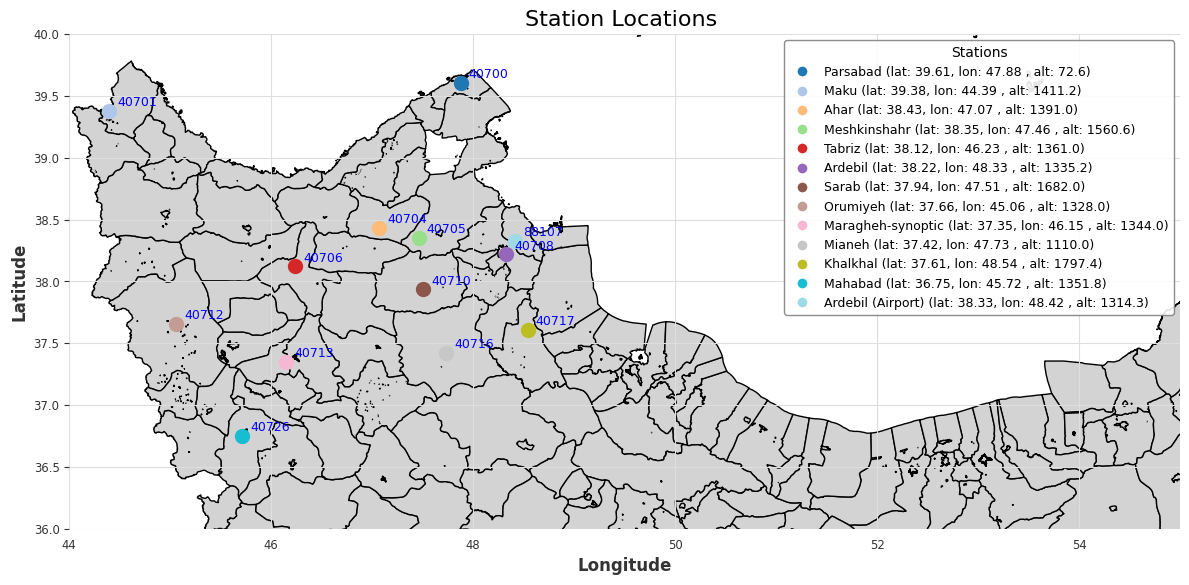

In [10]:
import matplotlib.cm as cm
# import matplotlib.colors as mcolors


world = gpd.read_file('ir_shp/gis_osm_places_a_free_1.shp')
df2 = pd.read_csv('../main_data.csv')
stations = df2[['station_id','station_name','station_elevation', 'lat', 'lon']].drop_duplicates()

# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(stations['lon'], stations['lat'])]

geo_df = gpd.GeoDataFrame(stations, geometry=geometry)


geo_df.set_crs(epsg=4326, inplace=True)


# Assign unique colors to each station
num_stations = len(geo_df)
cmap = cm.get_cmap('tab20', num_stations)
colors = [cmap(i) for i in range(num_stations)]
geo_df['color'] = colors

# Create plot
fig, ax = plt.subplots(figsize=(12, 8))
world.plot(ax=ax, color='lightgray', edgecolor='black')

# Plot each station with its unique color
for idx, row in geo_df.iterrows():
    ax.plot(row.geometry.x, row.geometry.y, marker='o', color=row.color, markersize=10)

# Offset and label with station_id
for x, y, label in zip(geo_df.geometry.x, geo_df.geometry.y, geo_df['station_id']):
    ax.text(x + 0.08, y + 0.04, str(label), fontsize=9, ha='left', color='blue')

# Zoom main map to upper north Iran
ax.set_xlim(44, 55)
ax.set_ylim(36, 40)

# Title and axes
plt.title('Station Locations ', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(True)

# Create custom legend using station name and unique color
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label=f"{row.station_name} (lat: {row.lat:.2f}, lon: {row.lon:.2f} , alt: {row.station_elevation})",
           markerfacecolor=row.color, markersize=8)
    for _, row in geo_df.iterrows()
]
# Add legend with background box
legend = ax.legend(
    handles=legend_elements, title="Stations", fontsize=9, title_fontsize=10, loc='upper right',
    frameon=True, fancybox=True, framealpha=0.9, edgecolor='gray'
)
legend.get_frame().set_facecolor('white')  # Set background color

# # Zoomed inset
# axins = inset_axes(ax, width="50%", height="50%", loc='upper right')
# world.plot(ax=axins, color='lightgray', edgecolor='black')
# for idx, row in geo_df.iterrows():
#     axins.plot(row.geometry.x, row.geometry.y, marker='o', color=row.color, markersize=10)
#     axins.text(row.geometry.x + 0.05, row.geometry.y + 0.03, str(row.station_id), fontsize=7, ha='left', color='blue')

# # Adjust inset zoom area so no point falls in blank space
# margin = 0.5
# xmin, xmax = geo_df.geometry.x.min() - margin, geo_df.geometry.x.max() + margin
# ymin, ymax = geo_df.geometry.y.min() - margin, geo_df.geometry.y.max() + margin
# axins.set_xlim(xmin, xmax)
# axins.set_ylim(ymin, ymax)
# axins.set_xticks([])
# axins.set_yticks([])
# axins.set_title("Closer View", fontsize=10)


# Final layout
plt.tight_layout()
plt.show()
